### Author
 - Gioele Modica

In [36]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from ipywidgets import interact, IntSlider
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Functions

In [37]:
def load_dicom_series(directory):
    """Load a series of DICOM files from a directory and return as 3D numpy array"""
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in sorted(os.listdir(directory))]
    slices = [f.pixel_array for f in files]
    return np.stack(slices, axis=0)

def load_single_dicom(filepath):
    """Load a single DICOM file"""
    ds = pydicom.dcmread(filepath)
    return ds.pixel_array

In [38]:
def extract_bounding_box(mask_volume):
    """Extract 3D bounding box coordinates from a binary mask volume"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    if len(props) == 0:
        return None
        
    bbox = props[0].bbox  # (min_z, min_y, min_x, max_z, max_y, max_x)
    return {
        'z_start': bbox[0],
        'z_end': bbox[3],
        'y_start': bbox[1],
        'y_end': bbox[4],
        'x_start': bbox[2],
        'x_end': bbox[5]
    }

def calculate_centroid(mask_volume):
    """Calculate 3D centroid coordinates from a binary mask volume"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    if len(props) == 0:
        return None
        
    centroid = props[0].centroid  # (z, y, x)
    return {
        'z': int(centroid[0]),
        'y': int(centroid[1]),
        'x': int(centroid[2])
    }

In [ ]:
def plot_slice_with_bbox(image_slice, mask_slice=None, bbox_coords=None, title=None):
    """Plot slice with mask and bounding box rectangle"""
    plt.figure(figsize=(10, 5))
    plt.imshow(image_slice, cmap='gray')
    
    if mask_slice is not None:
        mask_slice = np.ma.masked_where(mask_slice == 0, mask_slice)
        plt.imshow(mask_slice, cmap='autumn', alpha=0.3, label='Tumor Mask')
    
    if bbox_coords is not None:
        # Draw bounding box rectangle
        width = bbox_coords['x_end'] - bbox_coords['x_start']
        height = bbox_coords['y_end'] - bbox_coords['y_start']
        rect = plt.Rectangle((bbox_coords['x_start'], bbox_coords['y_start']),
                            width, height,
                            linewidth=2, edgecolor='lime', 
                            facecolor='none', label='Bounding Box')
        plt.gca().add_patch(rect)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def crop_to_bbox(volume, bbox):
    """Crop a 3D volume to bounding box dimensions"""
    return volume[bbox['z_start']:bbox['z_end'],
                bbox['y_start']:bbox['y_end'],
                bbox['x_start']:bbox['x_end']]

In [39]:
def region_growing_segmentation(image_volume, seed_point, threshold=20):
    """Perform 3D region growing segmentation from a seed point"""
    segmented = np.zeros_like(image_volume)
    z, y, x = seed_point['z'], seed_point['y'], seed_point['x']
    
    # Get seed value
    seed_value = image_volume[z, y, x]
    
    # Define 6-connectivity for 3D
    connectivity = [
        (-1, 0, 0), (1, 0, 0),
        (0, -1, 0), (0, 1, 0),
        (0, 0, -1), (0, 0, 1)
    ]
    
    # Initialize queue with seed point
    queue = [(z, y, x)]
    segmented[z, y, x] = 1
    
    while queue:
        current = queue.pop(0)
        
        for dz, dy, dx in connectivity:
            nz, ny, nx = current[0]+dz, current[1]+dy, current[2]+dx
            
            # Check if neighbor is within bounds
            if (0 <= nz < image_volume.shape[0] and 
                0 <= ny < image_volume.shape[1] and 
                0 <= nx < image_volume.shape[2]):
                
                # Check if neighbor is not already segmented and within threshold
                if (segmented[nz, ny, nx] == 0 and 
                    abs(int(image_volume[nz, ny, nx]) - int(seed_value)) < threshold):
                    
                    segmented[nz, ny, nx] = 1
                    queue.append((nz, ny, nx))
    
    return segmented

In [40]:
def compare_masks(ground_truth, predicted):
    """Compare two binary masks and calculate Dice and Jaccard coefficients"""
    # Assicuriamoci che le maschere abbiano le stesse dimensioni
    if ground_truth.shape != predicted.shape:
        # Trova la dimensione minima comune
        min_z = min(ground_truth.shape[0], predicted.shape[0])
        min_y = min(ground_truth.shape[1], predicted.shape[1])
        min_x = min(ground_truth.shape[2], predicted.shape[2])
        
        # Ritaglia entrambe le maschere alla stessa dimensione
        gt_cropped = ground_truth[:min_z, :min_y, :min_x]
        pred_cropped = predicted[:min_z, :min_y, :min_x]
    else:
        gt_cropped = ground_truth
        pred_cropped = predicted
    
    # Calcola le metriche sulle maschere ritagliate
    intersection = np.logical_and(gt_cropped, pred_cropped)
    union = np.logical_or(gt_cropped, pred_cropped)
    
    dice = 2 * intersection.sum() / (gt_cropped.sum() + pred_cropped.sum())
    jaccard = intersection.sum() / union.sum()
    
    return {
        'dice': dice,
        'jaccard': jaccard,
        'voxel_accuracy': (gt_cropped == pred_cropped).mean()
    }

In [41]:
# Plot centroid on the image

def plot_slice_with_centroid(image_slice, centroid_coords, title=None):
    """Plot a single slice with centroid marked"""
    plt.figure(figsize=(8, 8))
    plt.imshow(image_slice, cmap='gray')
    
    # Plot centroid (x and y are inverted in matplotlib's imshow)
    plt.scatter(centroid_coords['x'], centroid_coords['y'], 
                color='red', s=100, marker='x', linewidths=2,
                label='Centroid')
    
    if title:
        plt.title(title)
    
    plt.legend()
    plt.show()

In [42]:
def postprocess_segmentation(mask_volume, min_volume=100):
    """Remove small disconnected regions from segmentation"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    # Create new mask keeping only large enough regions
    cleaned = np.zeros_like(mask_volume)
    for prop in props:
        if prop.area >= min_volume:
            for coord in prop.coords:
                cleaned[coord[0], coord[1], coord[2]] = 1
                
    return cleaned

In [43]:
def find_optimal_threshold(image_volume, centroid, gt_mask, threshold_range=range(10, 20, 5)):
    best_threshold = 0
    best_dice = 0
    
    for threshold in tqdm(threshold_range, desc="Finding optimal threshold"):
        segmented = region_growing_segmentation(image_volume, centroid, threshold)
        metrics = compare_masks(gt_mask, segmented)
        
        if metrics['dice'] > best_dice:
            best_dice = metrics['dice']
            best_threshold = threshold
            print(f"New best threshold: {best_threshold}, Dice: {best_dice}")
    return best_threshold, best_dice

In [49]:
def plot_slice_with_masks(image_slice, gt_mask=None, pred_mask=None, title=None):
    """Plot a single slice with optional ground truth and predicted masks overlay"""
    plt.figure(figsize=(10, 5))
    
    plt.imshow(image_slice, cmap='gray')
    
    if gt_mask is not None:
        gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
        plt.imshow(gt_mask, cmap='autumn', alpha=0.3, label='Ground Truth')
    
    if pred_mask is not None:
        pred_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
        plt.imshow(pred_mask, cmap='winter', alpha=0.3, label='Predicted')
    
    if title:
        plt.title(title)
    
    plt.legend()
    plt.show()

def interactive_viewer(volume, gt_mask=None, pred_mask=None):
    """Create interactive viewer for volume inspection"""
    max_slice = volume.shape[0] - 1  # Calcola il massimo indice valido
    @interact(slice=IntSlider(min=0, max=max_slice, step=1, value=max_slice//2))
    def _view_slice(slice):
        # Verifica aggiuntiva per sicurezza
        slice = min(max(slice, 0), max_slice)
        plot_slice_with_masks(
            volume[slice],
            gt_mask[slice] if gt_mask is not None and gt_mask.shape[0] > slice else None,
            pred_mask[slice] if pred_mask is not None and pred_mask.shape[0] > slice else None,
            f'Slice {slice}'
        )

# Execution

In [45]:
# Load reference image and tumor mask
reference_volume = load_dicom_series('1493/30_EQP_Ax5.00mm')
tumor_mask = load_single_dicom('1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm')

# Normalize the reference volume
reference_volume = (reference_volume - np.min(reference_volume)) / (np.max(reference_volume) - np.min(reference_volume))

# Verify data loading
print(f"Reference volume shape: {reference_volume.shape}")
print(f"Tumor mask shape: {tumor_mask.shape}")

Reference volume shape: (58, 512, 512)
Tumor mask shape: (11, 512, 512)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bounding Box: {'z_start': 0, 'z_end': 9, 'y_start': 216, 'y_end': 288, 'x_start': 139, 'x_end': 212}
Centroid: {'z': 3, 'y': 247, 'x': 170}


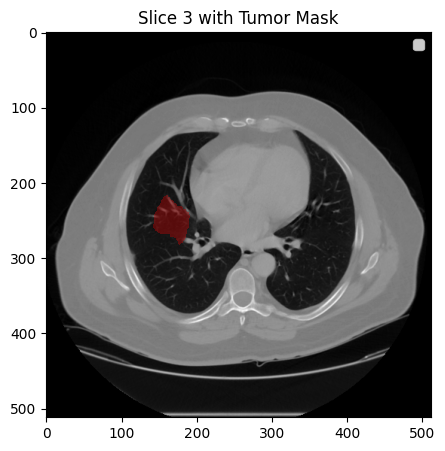


Visualizing centroid location...


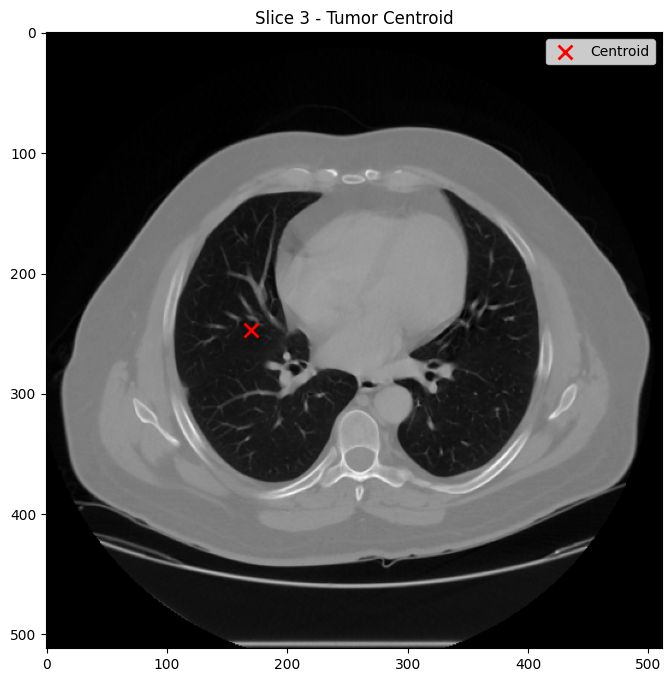

In [46]:
# Extract bounding box and centroid from tumor mask
bbox = extract_bounding_box(tumor_mask)
centroid = calculate_centroid(tumor_mask)

print("Bounding Box:", bbox)
print("Centroid:", centroid)

# Visualize the centroid slice
plot_slice_with_masks(
    reference_volume[centroid['z']],
    tumor_mask[centroid['z']],
    title=f"Slice {centroid['z']} with Tumor Mask"
)

print("\nVisualizing centroid location...")
plot_slice_with_centroid(
    reference_volume[centroid['z']],
    {'x': centroid['x'], 'y': centroid['y']},
    title=f"Slice {centroid['z']} - Tumor Centroid"
)

In [47]:

# Find optimal threshold
print("\nSearching for optimal threshold...")
optimal_th, optimal_dice = find_optimal_threshold(reference_volume, centroid, tumor_mask)
print(f"\nOptimal threshold found: {optimal_th} (Dice: {optimal_dice:.3f})")

# Perform segmentation with optimal threshold
segmented = region_growing_segmentation(reference_volume, centroid, optimal_th)

# Post-process the segmentation
segmented_clean = postprocess_segmentation(segmented)

# Compare results before and after post-processing
metrics_raw = compare_masks(tumor_mask, segmented)
metrics_clean = compare_masks(tumor_mask, segmented_clean)

print("\nMetrics BEFORE post-processing:")
print(f"Dice Coefficient: {metrics_raw['dice']:.3f}")
print(f"Jaccard Index: {metrics_raw['jaccard']:.3f}")
print(f"Voxel Accuracy: {metrics_raw['voxel_accuracy']:.3f}")

print("\nMetrics AFTER post-processing:")
print(f"Dice Coefficient: {metrics_clean['dice']:.3f}")
print(f"Jaccard Index: {metrics_clean['jaccard']:.3f}")
print(f"Voxel Accuracy: {metrics_clean['voxel_accuracy']:.3f}")


Searching for optimal threshold...


Finding optimal threshold:  50%|█████     | 1/2 [12:29<12:29, 749.51s/it]

New best threshold: 10, Dice: 0.009485301096701268


Finding optimal threshold: 100%|██████████| 2/2 [27:53<00:00, 836.66s/it]



Optimal threshold found: 10 (Dice: 0.009)

Metrics BEFORE post-processing:
Dice Coefficient: 0.009
Jaccard Index: 0.005
Voxel Accuracy: 0.005

Metrics AFTER post-processing:
Dice Coefficient: 0.009
Jaccard Index: 0.005
Voxel Accuracy: 0.005


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Visualizing results at centroid slice...


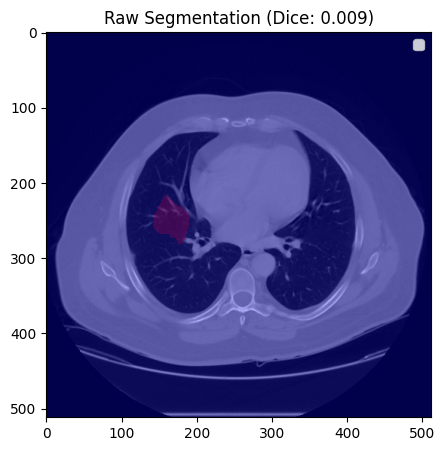

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


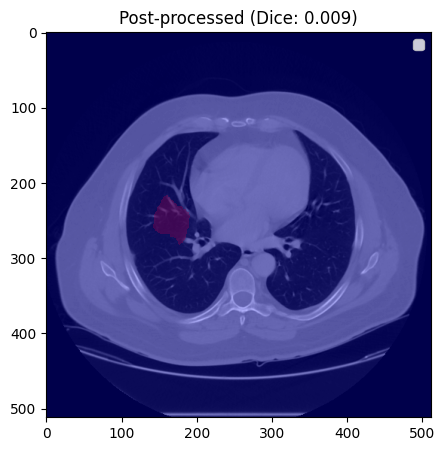


Creating interactive viewer...


interactive(children=(IntSlider(value=28, description='slice', max=57), Output()), _dom_classes=('widget-inter…

In [50]:
# Visualize results
print("\nVisualizing results at centroid slice...")
plot_slice_with_masks(
    reference_volume[centroid['z']],
    tumor_mask[centroid['z']],
    segmented[centroid['z']],
    title=f"Raw Segmentation (Dice: {metrics_raw['dice']:.3f})"
)

plot_slice_with_masks(
    reference_volume[centroid['z']],
    tumor_mask[centroid['z']],
    segmented_clean[centroid['z']],
    title=f"Post-processed (Dice: {metrics_clean['dice']:.3f})"
)

# Create interactive viewer for full volume inspection
print("\nCreating interactive viewer...")
interactive_viewer(reference_volume, gt_mask=tumor_mask, pred_mask=segmented_clean)